# try on 230613

In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.nn.functional as F

import matplotlib.pyplot as plt

from collections import OrderedDict

import pandas as pd
import seaborn as sns


/home/secondvoca/anaconda3/envs/torch/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Download training data from open datasets.
training_data = datasets.MNIST(
  root="data",
  train=True,
  download=True,
  transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
  root="data",
  train=False,
  download=True,
  transform=ToTensor(),
)

In [3]:
batch_size = 128

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
  print(f"Shape of X [N, C, H, W]: {X.shape} {X.dtype}")
  print(f"Shape of y: {y.shape} {y.dtype}")
  break

Shape of X [N, C, H, W]: torch.Size([128, 1, 28, 28]) torch.float32
Shape of y: torch.Size([128]) torch.int64


In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [15]:
encoder = nn.Sequential(
  nn.Flatten(),
  nn.Linear(784, 512),
  nn.Tanh(),
  nn.Linear(512, 128),
  nn.Tanh(),
  nn.Linear(128, 64),
  nn.Tanh(),
  nn.Linear(64, 10),
)

decoder = nn.Sequential(
  nn.Linear(5, 64),
  nn.Tanh(),
  nn.Linear(64, 128),
  nn.Tanh(),
  nn.Linear(128, 512),
  nn.Tanh(),
  nn.Linear(512, 784),
  nn.Sigmoid(),
  nn.Unflatten(1, [1, 28, 28])
)

In [16]:
model = nn.Sequential(OrderedDict([
          ('encoder', encoder),
          ('decoder', decoder),
        ])).to(device)

optimizer = torch.optim.Adam(model.parameters())

In [17]:
def train_5_hs(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))

  model.train()
  for batch, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)

    # Compute prediction error
    h = model.get_submodule('encoder')(x)
    sigma = F.softplus(h[:, 5:]) + 1e-6
    mu = h[:, :5]
    sampled_h = torch.randn([h.shape[0], 5]).to(device) * sigma + mu
    kld = (0.5 * (mu.square() + sigma.square() - sigma.square().log() - 1)).sum(dim=1).mean()
    pred = model.get_submodule('decoder')(sampled_h)
    likelihood = (x*pred.log() + (1 - x)*(1 - pred).log()).sum(dim=[1,2,3]).mean()
    loss = -likelihood + kld

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist

In [188]:
def train_loss_balance(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))

  model.train()
  for batch, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)

    # Compute prediction error
    h = model.get_submodule('encoder')(x)
    sigma = F.softplus(h[:, 2:4]) + 1e-6
    mu = h[:, :2]
    alpha = F.softplus(h[:, 4]) + 1
    sampled_h = torch.randn([h.shape[0], 2]).to(device) * sigma + mu
    kld = ((0.5 * (mu.square() + sigma.square() - sigma.square().log() - 1)).sum(dim=1)*alpha).mean()
    pred = model.get_submodule('decoder')(sampled_h)
    likelihood = ((x*pred.log() + (1 - x)*(1 - pred).log()).sum(dim=[1,2,3])).mean()
    loss = -likelihood + kld + (-likelihood - kld).square().sqrt()

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist

In [156]:
def train_just_autoencoder(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))

  model.train()
  for batch, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)

    # Compute prediction error
    pred = model(x)
    loss = -(x*pred.log() + (1 - x)*(1 - pred).log()).sum(dim=[1,2,3]).mean()

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist

In [144]:
def train_no_sampling_with_balance(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))

  model.train()
  for batch, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)

    # Compute prediction error
    h = model.get_submodule('encoder')(x)
    sigma = F.softplus(h[:, 2:]) + 1e-6
    mu = h[:, :2]
    # sampled_h = torch.randn([h.shape[0], 2]).to(device) * sigma + mu
    kld = (0.5 * (mu.square() + sigma.square() - sigma.square().log() - 1)).sum(dim=1).mean()
    pred = model.get_submodule('decoder')(mu)
    likelihood = (x*pred.log() + (1 - x)*(1 - pred).log()).sum(dim=[1,2,3]).mean()
    loss = -likelihood + kld + (-likelihood + kld).square().sqrt()

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist

In [136]:
def train_with_balance(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))

  model.train()
  for batch, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)

    # Compute prediction error
    h = model.get_submodule('encoder')(x)
    sigma = F.softplus(h[:, 2:]) + 1e-6
    mu = h[:, :2]
    sampled_h = torch.randn([h.shape[0], 2]).to(device) * sigma + mu
    kld = (0.5 * (mu.square() + sigma.square() - sigma.square().log() - 1)).sum(dim=1).mean()
    pred = model.get_submodule('decoder')(sampled_h)
    likelihood = (x*pred.log() + (1 - x)*(1 - pred).log()).sum(dim=[1,2,3]).mean()
    loss = -likelihood + kld + (-likelihood + kld).square().sqrt()

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist

In [128]:
def train_no_sampling(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))

  model.train()
  for batch, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)

    # Compute prediction error
    h = model.get_submodule('encoder')(x)
    sigma = F.softplus(h[:, 2:]) + 1e-6
    mu = h[:, :2]
    # sampled_h = torch.randn([h.shape[0], 2]).to(device) * sigma + mu
    kld = (0.5 * (mu.square() + sigma.square() - sigma.square().log() - 1)).sum(dim=1).mean()
    pred = model.get_submodule('decoder')(mu)
    likelihood = (x*pred.log() + (1 - x)*(1 - pred).log()).sum(dim=[1,2,3]).mean()
    loss = -likelihood + kld

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist

In [7]:
def train(model, dataloader, optimizer):

  hist = torch.zeros(len(dataloader))

  model.train()
  for batch, (x, y) in enumerate(dataloader):
    x, y = x.to(device), y.to(device)

    # Compute prediction error
    h = model.get_submodule('encoder')(x)
    sigma = F.softplus(h[:, 2:]) + 1e-6
    mu = h[:, :2]
    sampled_h = torch.randn([h.shape[0], 2]).to(device) * sigma + mu
    kld = (0.5 * (mu.square() + sigma.square() - sigma.square().log() - 1)).sum(dim=1).mean()
    pred = model.get_submodule('decoder')(sampled_h)
    likelihood = (x*pred.log() + (1 - x)*(1 - pred).log()).sum(dim=[1,2,3]).mean()
    loss = -likelihood + kld

    # Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    hist[batch] = loss.item()

  return hist

In [18]:
model.to(device)
hist = torch.zeros(0)
for _ in range(20):
  tmp = train_5_hs(model, train_dataloader, optimizer)
  hist = torch.cat([hist, tmp])
  

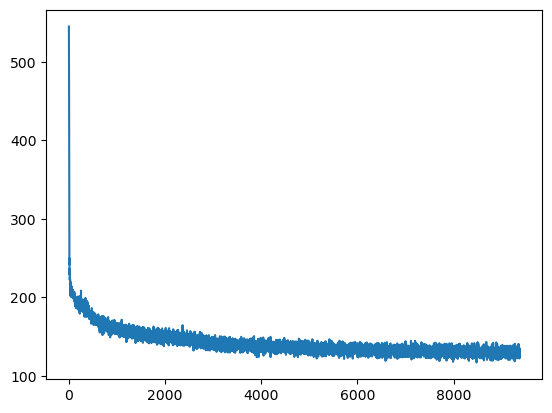

In [19]:
plt.plot(hist)
plt.show()

In [22]:
# df = pd.DataFrame(columns=['x', 'y', 'label'])
df = pd.DataFrame(columns=['x0', 'x1', 'x2', 'x3', 'x4', 'label'])
df

model.to('cpu')

idx = 0
for X, y in test_dataloader:
  h = model.get_submodule('encoder')(X)
  # mu = h[:, :2].detach().numpy()
  mu = h[:, :5].detach().numpy()
  # mu = h.detach().numpy()
  
  tmp = pd.DataFrame(
    {
      # 'x': mu[:, 0],
      # 'y': mu[:, 1],
      'x0': mu[:, 0],
      'x1': mu[:, 1],
      'x2': mu[:, 2],
      'x3': mu[:, 3],
      'x4': mu[:, 4],
      'label': y
    }
  )
  df = df.append(tmp, ignore_index = True)

  idx += 1
  if idx > 50:
    break

/tmp/ipykernel_2102601/3127927781.py:26: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(tmp, ignore_index = True)


<AxesSubplot:xlabel='x', ylabel='y'>

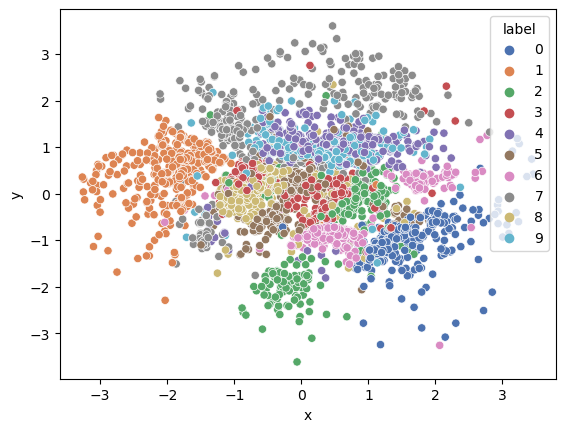

In [100]:
sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")

<AxesSubplot:xlabel='x', ylabel='y'>

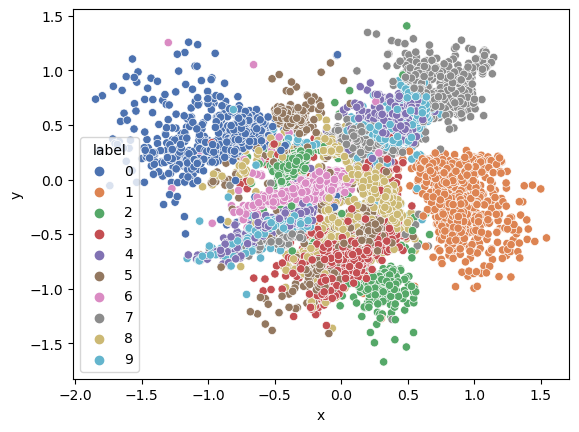

In [132]:
sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")

<AxesSubplot:xlabel='x', ylabel='y'>

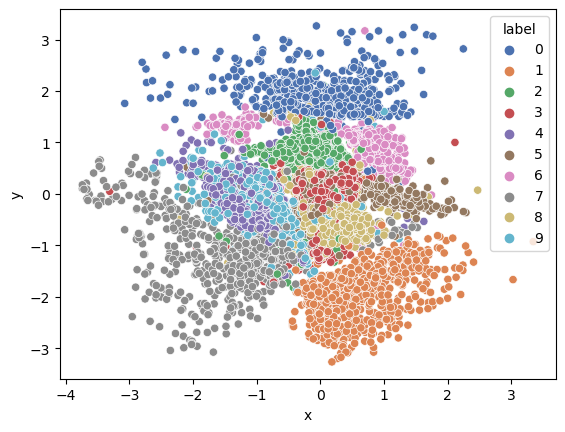

In [140]:
sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")

<AxesSubplot:xlabel='x', ylabel='y'>

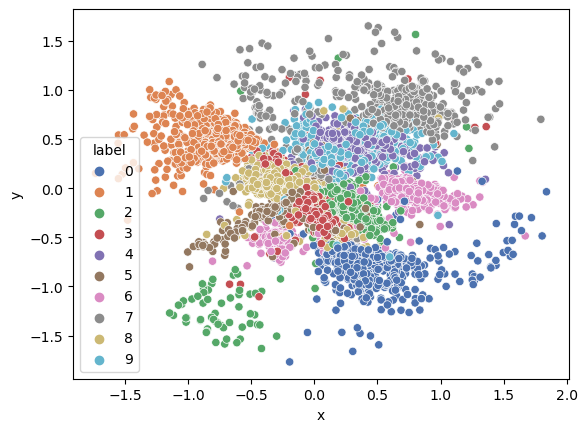

In [148]:
sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")

<AxesSubplot:xlabel='x', ylabel='y'>

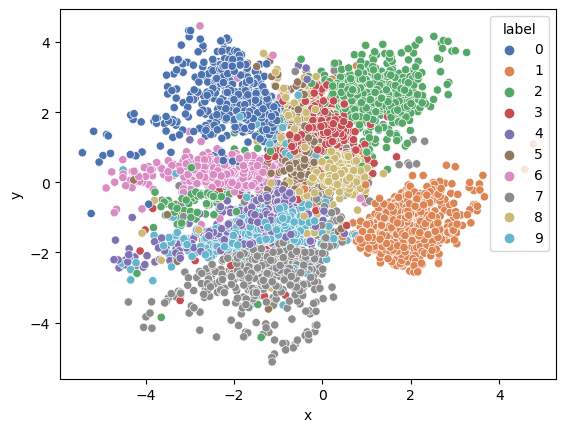

In [160]:
sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")

<AxesSubplot:xlabel='x', ylabel='y'>

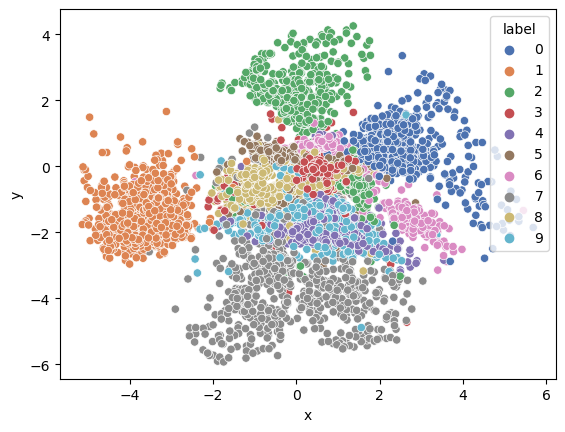

In [192]:
sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")

<AxesSubplot:xlabel='x', ylabel='y'>

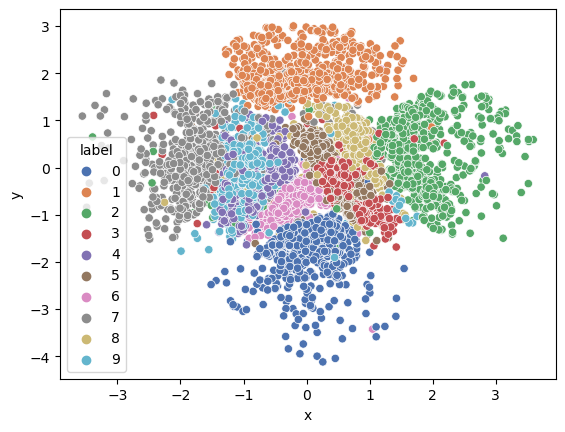

In [12]:
sns.scatterplot(data=df, x="x", y="y", hue="label", palette="deep")

In [24]:
df.describe()

,x0,x1,x2,x3,x4
count,6528.000000,6528.000000,6528.000000,6528.000000,6528.000000
mean,-0.007825,-0.131566,-0.154407,0.007003,-0.011021
std,0.027910,0.955889,0.979925,0.028175,1.051565
min,-0.159889,-3.748571,-3.346321,-0.149596,-3.379629
25%,-0.023885,-0.767336,-0.837217,-0.009023,-0.649569
50%,-0.009223,-0.001697,-0.192138,0.005976,-0.041994
75%,0.008209,0.479570,0.495946,0.021732,0.518806
max,0.127666,3.278819,3.480124,0.184076,3.153025


<AxesSubplot:xlabel='x1', ylabel='x2'>

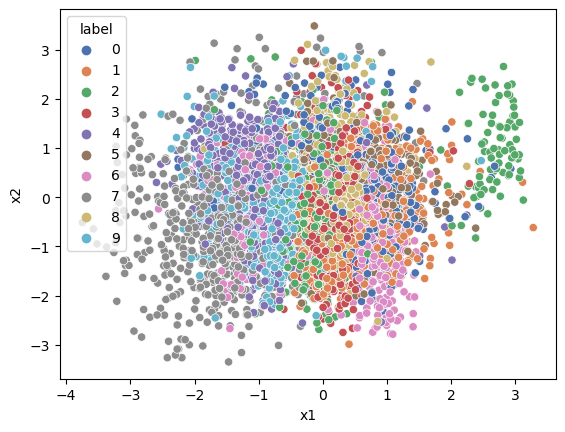

In [25]:
sns.scatterplot(data=df, x="x1", y="x2", hue="label", palette="deep")

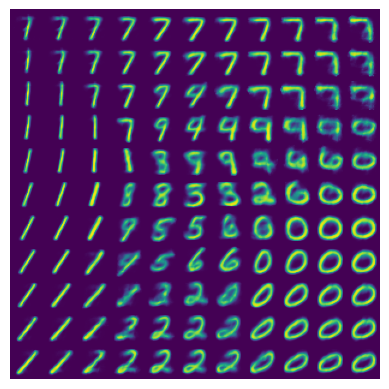

In [124]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-3, 3, 11), torch.linspace(-3, 3, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r)
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

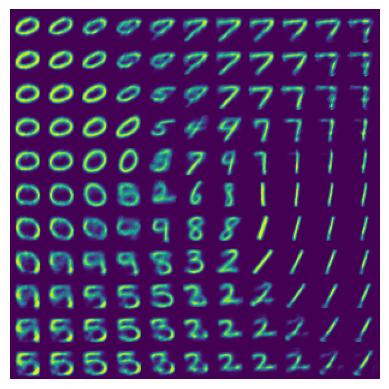

In [133]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-2, 2, 11), torch.linspace(-2, 2, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r)
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

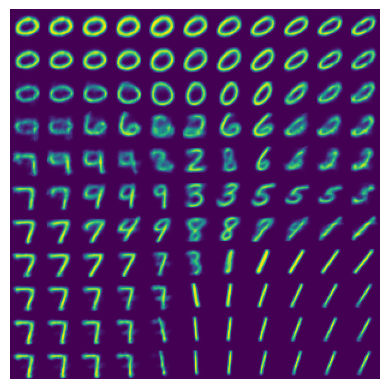

In [141]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-3, 3, 11), torch.linspace(-3, 3, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r)
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

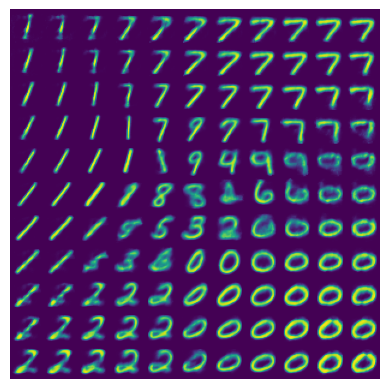

In [149]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-2, 2, 11), torch.linspace(-2, 2, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r)
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

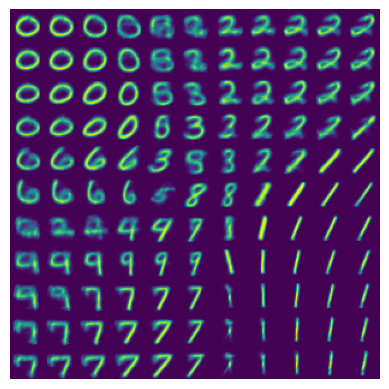

In [161]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-4, 4, 11), torch.linspace(-4, 4, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r)
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

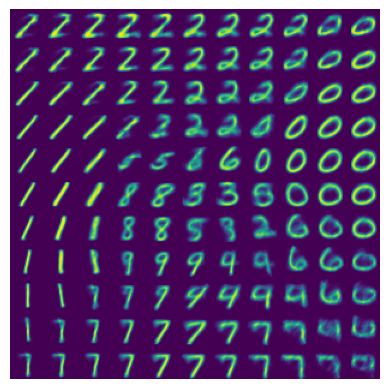

In [193]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-4, 4, 11), torch.linspace(-4, 4, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r)
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

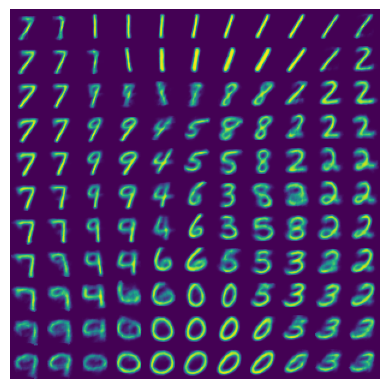

In [13]:
grid_x, grid_y = torch.meshgrid(torch.linspace(-2, 2, 11), torch.linspace(-2, 2, 11), indexing='xy')
points = torch.stack([grid_x, grid_y], dim=2)

def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r)
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

In [27]:
a = torch.zeros(11, 11, 5)
b = torch.rand(11, 11, 2)
a[:, :, 1:3] = b
a[0,0]

tensor([0.0000, 0.0642, 0.1933, 0.0000, 0.0000])

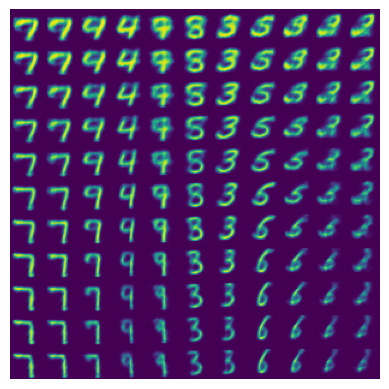

In [28]:
points = torch.zeros(11, 11, 5)
grid_x, grid_y = torch.meshgrid(torch.linspace(-3, 3, 11), torch.linspace(-3, 3, 11), indexing='xy')
points[:, :, 1:3] = torch.stack([grid_x, grid_y], dim=2)


def plot_reconstructed(decoder, points):
  w = 28
  n = len(points)
  img = torch.zeros((n*w, n*w))
  for i, r in enumerate(points):
    tmps = decoder(r)
    for j, tmp in enumerate(tmps):
      img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = tmp[0]
  plt.axis('off')
  plt.imshow(img)

with torch.no_grad():
  plot_reconstructed(model.get_submodule('decoder'), points)
  

## questions
- 잠재 벡터로의 출력을 0에서 1로 만드는 시그모이드 함수를 사용하면, 디코더는 0에서 1 이외의 잠재 벡터에 대하여 어떠한 사상을 학습하게 될까?